In [1]:
import numpy as np 
import matplotlib.pylab as plt 
from scipy.stats import multivariate_normal, norm
from scipy.optimize import minimize

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

In [2]:
def model_sin(xvalues, parameters):
    
    function = parameters[0] * np.sin(parameters[1] * xvalues)
    gradient_param_0 = np.sin(parameters[1] * xvalues)
    gradient_param_1 = parameters[0] * xvalues * np.cos(parameters[1] * xvalues)
    
    # this is of shape Ndata x 2 
    gradient = np.vstack([gradient_param_0, gradient_param_1]).T
    return function, gradient

In [3]:
def model_quad(xvalues, parameters):
    factor = xvalues
    function = parameters[0] * factor * xvalues**2 + parameters[1] * xvalues
    gradient = np.vstack([factor * xvalues**2, xvalues]).T
    return function, gradient

In [4]:
def calculate_mle(data, invcov, design):
    invterm = np.linalg.inv(design.T @ invcov @ design)
    mean = invterm @ design.T @ invcov @ data
    return mean 

In [5]:
def log_evidence_calculations(Lambda, covPrior, covNoise, data, compData):
    invterm = np.linalg.inv(Lambda + np.linalg.inv(covPrior))
    a_quant = 0.5 * compData @ invterm @ compData
    d_quant = np.linalg.slogdet(2.0 * np.pi * invterm)[1] - np.linalg.slogdet(2.0 * np.pi * covPrior)[1]
    
    chi2_comp = -0.5 * compData @ np.linalg.inv(Lambda) @ compData
    chi2_uncomp = -0.5 * data @ np.linalg.inv(covNoise) @ data
    det_comp = np.linalg.slogdet(2.0 * np.pi * Lambda)[1]
    det_uncomp = np.linalg.slogdet(2.0 * np.pi * covNoise)[1]
    
    log_evi_comp = a_quant + chi2_comp + 0.5 * (d_quant - det_comp)
    log_evi_uncomp = a_quant + chi2_uncomp + 0.5 * (d_quant - det_uncomp)
    
    return log_evi_comp, log_evi_uncomp

In [6]:
def log_likelihood_sin(beta, x, data, invcov):
    model = model_sin(x, beta)
    diff = data - model[0]
    chi2 = diff @ invcov @ diff
    return -0.5*chi2

def log_likelihood_quad(theta, x, data, invcov):
    model = model_quad(x, theta)
    diff = data - model[0]
    chi2 = diff @ invcov @ diff
    return -0.5*chi2


nll_sin = lambda *args: -log_likelihood_sin(*args)
nll_quad = lambda *args: -log_likelihood_quad(*args)

## Noise and Priors

In [7]:
sigma = 0.5
minx = 0.0 
maxx = np.pi 
ndata = 100
priorwidth = 10

In [8]:
noise_cov = np.diag(np.ones(ndata)*sigma**2)
noise_invcov = np.diag(1./(np.ones(ndata)*sigma**2))

In [9]:
# we will use beta to denote A and omega 
# we will use theta to denote a and b 
mean_beta = np.zeros(2)
mean_theta = np.zeros(2)

cov_beta = priorwidth * np.eye(2)
cov_theta = priorwidth * np.eye(2)

invcov_beta = np.linalg.inv(cov_beta)
invcov_theta = np.linalg.inv(cov_theta)

# priors 

p_beta = multivariate_normal(mean_beta, cov_beta)
p_theta = multivariate_normal(mean_theta, cov_theta)

In [10]:
param_1_fid = np.array([4.0, 0.75])
param_2_fid = np.array([-1.0, 4.0])

xvalues = np.linspace(minx, maxx, ndata)
model_1_fid, grad_1_fid = model_sin(xvalues, param_1_fid)
model_2_fid, grad_2_fid = model_quad(xvalues, param_2_fid)

In [11]:
epsilon = np.random.randn(ndata) * sigma
data = model_1_fid + epsilon

In [12]:
initial_sin = param_1_fid + 0.1 * np.random.randn(2)
soln_sin = minimize(nll_sin, initial_sin, args=(xvalues, data, noise_invcov))
mle_sin = soln_sin.x

initial_quad = param_2_fid + 0.1 * np.random.randn(2)
soln_quad = minimize(nll_quad, initial_quad, args=(xvalues, data, noise_invcov))
mle_quad = soln_quad.x

In [13]:
theory_mle_sin, grad_mle_sin = model_sin(xvalues, mle_sin)
theory_mle_quad, grad_mle_quad = model_quad(xvalues, mle_quad)

In [14]:
B_sin = noise_invcov @ grad_1_fid # grad_mle_sin # 
B_quad = noise_invcov @  grad_2_fid # grad_mle_quad #

In [15]:
X_data = data - model_1_fid # theory_mle_sin #
Y_sin = B_sin.T @ X_data
Y_quad = B_quad.T @ X_data

In [16]:
Lambda_sin = B_sin.T @ noise_cov @ B_sin
Lambda_quad = B_quad.T @ noise_cov @ B_quad

In [17]:
det_sin = np.linalg.slogdet(2.0 * np.pi * Lambda_sin)[1]
det_quad = np.linalg.slogdet(2.0 * np.pi * Lambda_quad)[1]

chi2_sin = Y_sin @ np.linalg.inv(Lambda_sin) @ Y_sin
chi2_quad = Y_quad @ np.linalg.inv(Lambda_quad) @ Y_quad

In [18]:
log_evi_sin_comp, log_evi_sin_uncomp = log_evidence_calculations(Lambda_sin, cov_beta, noise_cov, X_data, Y_sin)
log_evi_quad_comp, log_evi_quad_uncomp = log_evidence_calculations(Lambda_quad, cov_theta, noise_cov, X_data, Y_quad)

log_bf_comp = log_evi_sin_comp - log_evi_quad_comp
log_bf_uncomp = log_evi_sin_uncomp - log_evi_quad_uncomp
delta_bf = log_bf_comp - log_bf_uncomp

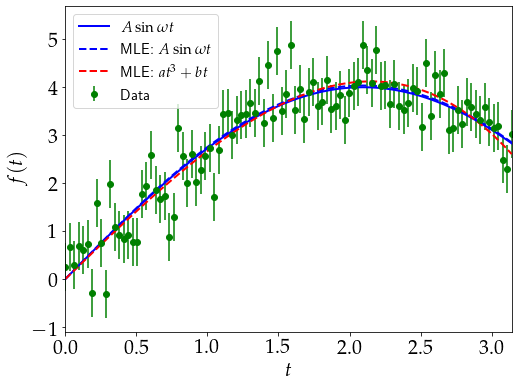

In [19]:
plt.figure(figsize = (8, 6))
plt.errorbar(xvalues, data, yerr = sigma, fmt = 'go', label = 'Data')
plt.plot(xvalues, model_1_fid, c = 'b', label = r'$A\,\textrm{sin}\,\omega t$', lw = 2)
# plt.plot(xvalues, model_2_fid, c = 'r', label = r'$at^{2} + bt$', lw=2)
plt.plot(xvalues, theory_mle_sin, c = 'b', label = r'MLE: $A\,\textrm{sin}\,\omega t$', lw = 2, linestyle = '--')
plt.plot(xvalues, theory_mle_quad, c = 'r', label = r'MLE: $at^{3} + bt$', lw=2, linestyle = '--')
plt.xlim(minx, maxx)
plt.ylabel(r'$f(t)$', fontsize = fontSize)
plt.xlabel(r'$t$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.show()

In [20]:
log_bf_comp

2.401343618360169

In [21]:
log_bf_uncomp

1.1838500244548982

## Repeating the above $n$ times

In [ ]:
# MLE for sinusoidal model and quadratic model
# -----------------------------------------------------------------------------------------
#         initial_sin = param_1_fid + 0.1 * np.random.randn(2)
#         soln_sin = minimize(nll_sin, initial_sin, args=(xvalues, data, noise_invcov))
#         mle_sin = soln_sin.x

#         initial_quad = param_2_fid + 0.1 * np.random.randn(2)
#         soln_quad = minimize(nll_quad, initial_quad, args=(xvalues, data, noise_invcov))
#         mle_quad = soln_quad.x

#         theory_mle_sin, grad_mle_sin = model_sin(xvalues, mle_sin)
#         theory_mle_quad, grad_mle_quad = model_quad(xvalues, mle_quad)
# -----------------------------------------------------------------------------------------

In [22]:
def repetitions(ntrials):
    
    record = dict()
    record['log_evi_sin_uncomp'] = list()
    record['log_evi_quad_uncomp'] = list()
    record['log_evi_sin_comp'] = list()
    record['log_evi_quad_comp'] = list()
    record['log_bf_comp'] = list()
    record['log_bf_uncomp'] = list()
    record['delta_log_bf'] = list()
    
    for i in range(ntrials):

        epsilon = np.random.randn(ndata) * sigma
        data = model_1_fid + epsilon
        
        # for evidence calculations
        B_sin = noise_invcov @ grad_1_fid # grad_mle_sin # 
        B_quad = noise_invcov @ grad_2_fid # grad_mle_quad # 
        
        X_data = data - model_1_fid # theory_mle_sin # 
        Y_sin = B_sin.T @ X_data
        Y_quad = B_quad.T @ X_data
               
        Lambda_sin = B_sin.T @ noise_cov @ B_sin
        Lambda_quad = B_quad.T @ noise_cov @ B_quad

        log_evi_sin_comp, log_evi_sin_uncomp = log_evidence_calculations(Lambda_sin, cov_beta, noise_cov, X_data, Y_sin)
        log_evi_quad_comp, log_evi_quad_uncomp = log_evidence_calculations(Lambda_quad, cov_theta, noise_cov, X_data, Y_quad)
    
        # print(log_evi_quad_comp)
        
        log_bf_comp = log_evi_sin_comp - log_evi_quad_comp
        log_bf_uncomp = log_evi_sin_uncomp - log_evi_quad_uncomp
        delta_log_bf = log_bf_comp - log_bf_uncomp

        record['log_evi_sin_uncomp'].append(log_evi_sin_uncomp)
        record['log_evi_quad_uncomp'].append(log_evi_quad_uncomp)
        record['log_evi_sin_comp'].append(log_evi_sin_comp)
        record['log_evi_quad_comp'].append(log_evi_quad_comp)
        record['log_bf_comp'].append(log_bf_comp)        
        record['log_bf_uncomp'].append(log_bf_uncomp)
        record['delta_log_bf'].append(delta_log_bf)
        
    return record

In [23]:
record = repetitions(5000)

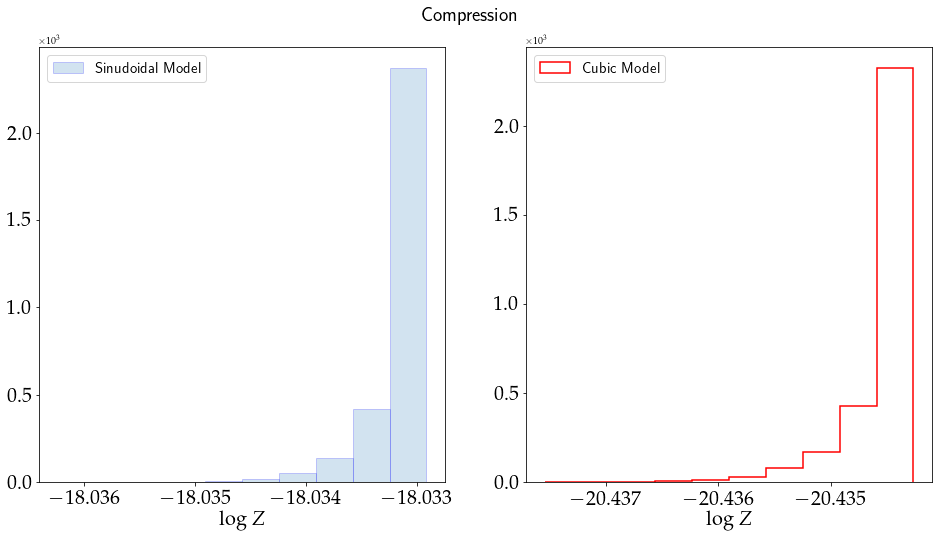

In [24]:
plt.figure(figsize = (16,8))

plt.suptitle('Compression', fontsize = fontSize, y=0.95)
plt.subplot(121)
plt.hist(record['log_evi_sin_comp'], density = True, edgecolor='b', linewidth=1.0, label = 'Sinudoidal Model', alpha = 0.2)
plt.xlabel(r'$\textrm{log }Z$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ticklabel_format(useOffset=False)
plt.legend(loc = 'upper left',prop={'family':'sans-serif', 'size':15})

plt.subplot(122)
plt.hist(record['log_evi_quad_comp'], density = True, edgecolor='r', linewidth=1.5, label = 'Cubic Model', histtype='step')
plt.xlabel(r'$\textrm{log }Z$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ticklabel_format(useOffset=False)
plt.legend(loc = 'upper left',prop={'family':'sans-serif', 'size':15})
plt.show()

plt.show()

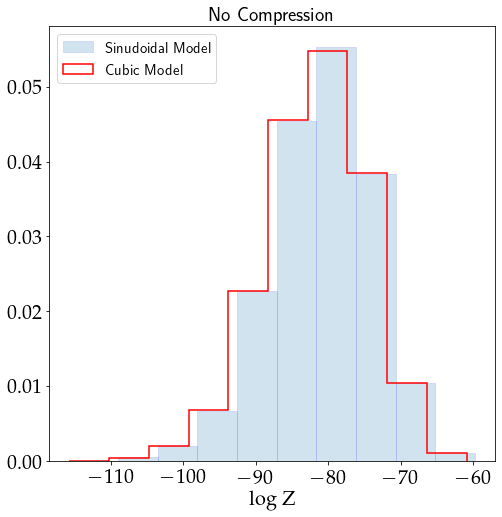

In [25]:
plt.figure(figsize = (8,8))
plt.title('No Compression', fontsize=fontSize)
plt.hist(record['log_evi_sin_uncomp'], density = True, edgecolor='b', linewidth=0.5, label = 'Sinudoidal Model', alpha = 0.2)
plt.hist(record['log_evi_quad_uncomp'], density = True, edgecolor='r', linewidth=1.5, label = 'Cubic Model', histtype='step')
plt.xlabel(r'$\textrm{log Z}$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'upper left',prop={'family':'sans-serif', 'size':15})
plt.show()

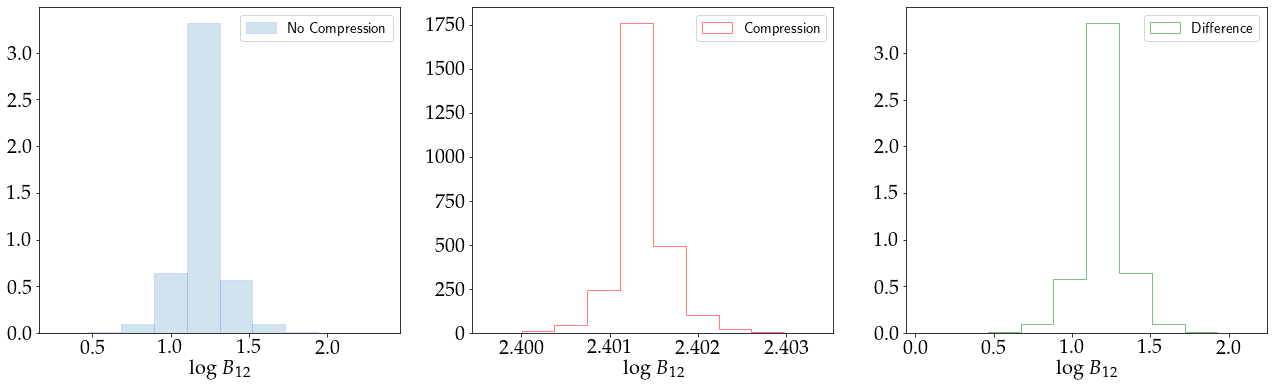

In [26]:
plt.figure(figsize = (22,6))
plt.subplot(131)
plt.hist(record['log_bf_uncomp'], density = True, edgecolor='b', linewidth=0.5, label = 'No Compression', alpha = 0.2)
plt.xlabel(r'$\textrm{log }B_{12}$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'upper right',prop={'family':'sans-serif', 'size':15})

plt.subplot(132)
plt.hist(record['log_bf_comp'], density = True, edgecolor='r', linewidth=0.5, label = 'Compression', histtype='step')
plt.xlabel(r'$\textrm{log }B_{12}$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'upper right',prop={'family':'sans-serif', 'size':15})

plt.subplot(133)
plt.hist(record['delta_log_bf'], density = True, edgecolor='g', linewidth=0.5, label = 'Difference', histtype='step')
plt.xlabel(r'$\textrm{log }B_{12}$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'upper right',prop={'family':'sans-serif', 'size':15})
plt.show()

In [27]:
std_comp = np.std(record["log_bf_comp"])
std_uncomp = np.std(record["log_bf_uncomp"])
print(f'The standard deviation in the distribution in log-BF for the compressed case is   : {std_comp:.2e}')
print(f'The standard deviation in the distribution in log-BF for the uncompressed case is : {std_uncomp:.2e}')

The standard deviation in the distribution in log-BF for the compressed case is   : 2.83e-04
The standard deviation in the distribution in log-BF for the uncompressed case is : 1.43e-01


In [28]:
# ndata = 200, sigma = 1.0
# The standard deviation in the distribution in log-BF for the compressed case is   : 5.80e-04
# The standard deviation in the distribution in log-BF for the uncompressed case is : 1.46e-01

# ndata = 200, sigma = 0.5
# The standard deviation in the distribution in log-BF for the compressed case is   : 1.47e-04
# The standard deviation in the distribution in log-BF for the uncompressed case is : 1.42e-01

# ndata = 100, sigma = 1.0
# The standard deviation in the distribution in log-BF for the compressed case is   : 1.23e-03
# The standard deviation in the distribution in log-BF for the uncompressed case is : 1.40e-01

# ndata = 100, sigma = 0.5
# The standard deviation in the distribution in log-BF for the compressed case is   : 2.91e-04
# The standard deviation in the distribution in log-BF for the uncompressed case is : 1.47e-01

In [29]:
# 2 x sigma
5.8/1.47

3.945578231292517

In [30]:
# 2 x sigma
12.3/2.91

4.22680412371134

In [31]:
# 2 x number of data
1.23e-03 / 5.80e-04

2.1206896551724137

In [32]:
# 2 x number of data
2.91e-04/1.47e-04

1.979591836734694